In [4]:
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
from scipy import stats

# import theano.tensor as tt
# import theano

import datetime
print(f"Last Run {datetime.datetime.now()}")

Last Run 2023-04-18 01:40:03.031876


In [14]:
az.style.use("arviz-viridish")

In [6]:
def generate_sales(*, days, mean, std, label):
    np.random.seed(0)
    df = pd.DataFrame(index=range(1, days+1), columns=["customers", "sales"])
    for day in range(1, days+1):
        num_customers = stats.randint(30, 100).rvs()+1
        
        # This is correct as there is an independent draw for each customers orders
        dollar_sales = stats.norm(mean, std).rvs(num_customers).sum()
        
        df.loc[day, "customers"] = num_customers
        df.loc[day, "sales"] = dollar_sales
        
    # Fix the types as not to cause Theano errors
    df = df.astype({'customers': 'int32', 'sales': 'float32'})
    
    # Sorting will make plotting the posterior predictive easier later
    df["Food_Category"] = label
    df = df.sort_values("customers")
    return df

In [16]:
pizza_df = generate_sales(days=365, mean=13, std=5, label="Pizza")
sandwich_df = generate_sales(days=100, mean=6, std=5, label="Sandwich")

salad_days = 5
salad_df = generate_sales(days=salad_days, mean=8 ,std=3, label="Salad")

In [17]:
sales_df = pd.concat([pizza_df, sandwich_df, salad_df]).reset_index(drop=True)
sales_df["Food_Category"] = pd.Categorical(sales_df["Food_Category"])
sales_df.head()

,customers,sales,Food_Category
0,31,459.895203,Pizza
1,31,401.147736,Pizza
2,31,413.345245,Pizza
3,31,371.909241,Pizza
4,32,433.797089,Pizza


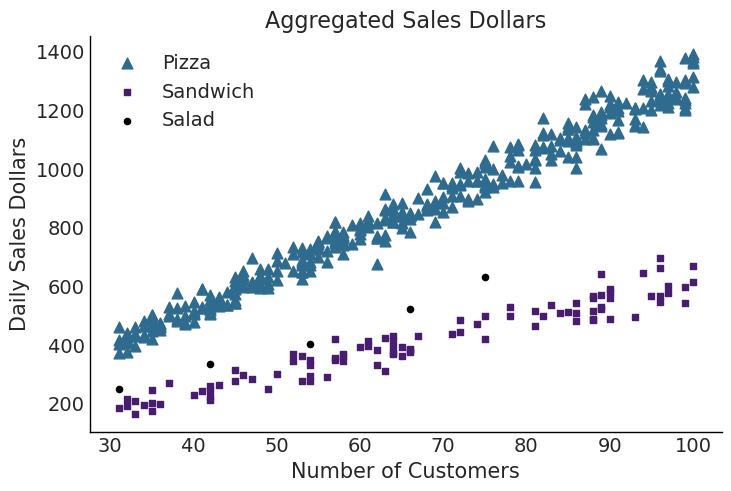

In [18]:
fig, ax = plt.subplots()
pizza_df.plot(x="customers", y="sales", kind="scatter", ax=ax, c="C1", label="Pizza", marker="^", s=60);
sandwich_df.plot(x="customers", y="sales", kind="scatter", ax=ax,  label="Sandwich", marker="s");
salad_df.plot(x="customers", y="sales", kind="scatter", ax=ax, label="Salad", c="C4");

ax.set_xlabel("Number of Customers")
ax.set_ylabel("Daily Sales Dollars")
ax.set_title("Aggregated Sales Dollars")
ax.legend()

In [22]:
customers = sales_df.loc[:, "customers"].values
sales_observed = sales_df.loc[:, "sales"].values
food_category = pd.Categorical(sales_df["Food_Category"])

with pm.Model() as model_sales_unpooled:
    σ = pm.HalfNormal("σ", 20, shape=3)
    β = pm.Normal("β", mu=10, sigma=10, shape=3)
    
    μ = pm.Deterministic("μ", β[food_category.codes] *customers)
    
    sales = pm.Normal("sales", mu=μ, sigma=σ[food_category.codes],
                      observed=sales_observed)
    
    trace_sales_unpooled = pm.sample(target_accept=.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


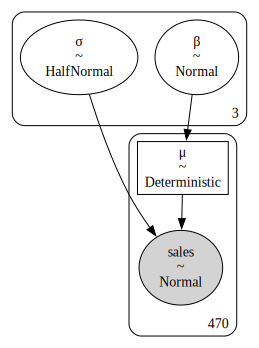

In [23]:
pm.model_to_graphviz(model_sales_unpooled)

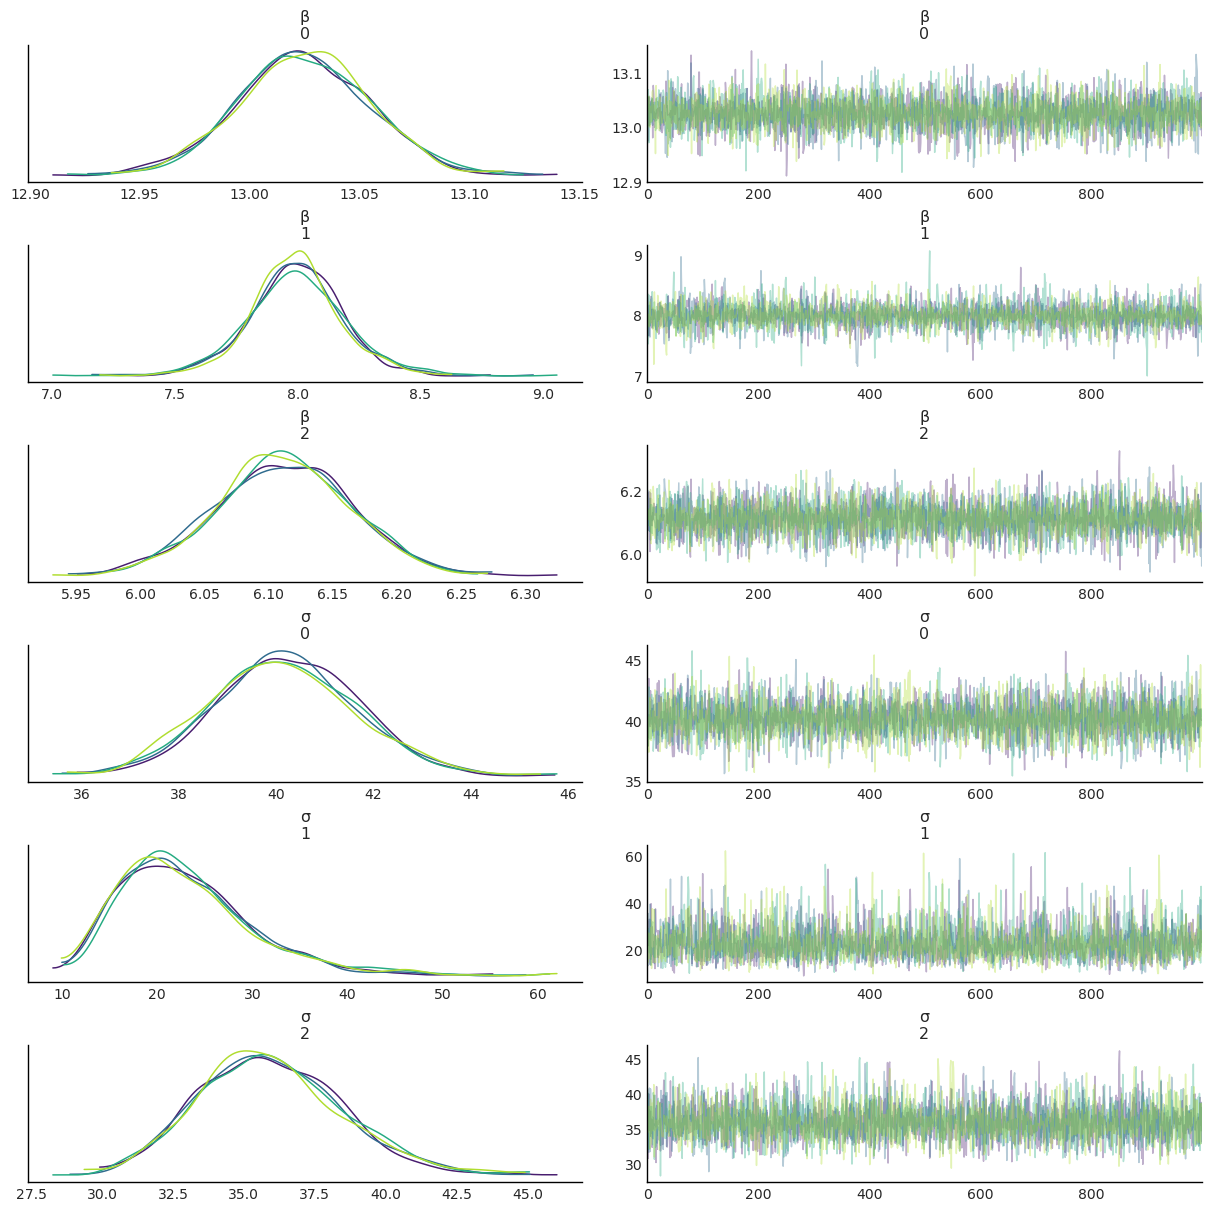

In [25]:
az.plot_trace(trace_sales_unpooled, var_names=["β", "σ"], compact=False);

Text(0.5, 1.0, 'β parameter estimates 94% HDI')

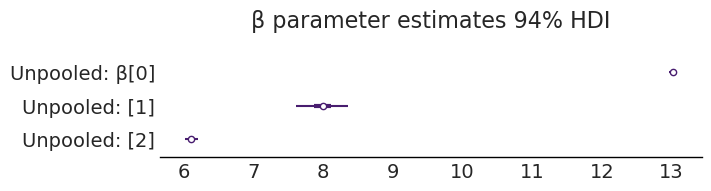

In [28]:
axes = az.plot_forest([trace_sales_unpooled],
                      model_names = ["Unpooled",],
                      var_names=["β"], combined=True, figsize=(7, 1.8));
axes[0].set_title("β parameter estimates 94% HDI")

Text(0.5, 1.0, 'σ parameter estimates 94% HDI')

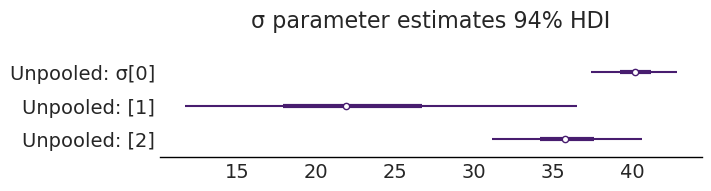

In [30]:
axes = az.plot_forest([trace_sales_unpooled,],
                      model_names = ["Unpooled",],
                      var_names=["σ"], combined=True, figsize=(7, 1.8));
axes[0].set_title("σ parameter estimates 94% HDI")

In [31]:
with pm.Model() as model_sales_pooled:
    σ = pm.HalfNormal("σ", 20)
    β = pm.Normal("β", mu=10, sigma=10)

    μ = pm.Deterministic("μ", β * customers)
    
    sales = pm.Normal("sales", mu=μ, sigma=σ,
                      observed=sales_observed)
                        
    inf_data_sales_pooled = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


In [32]:
with model_sales_pooled:
    ppc_sales_pooled = pm.sample_posterior_predictive(inf_data_sales_pooled)

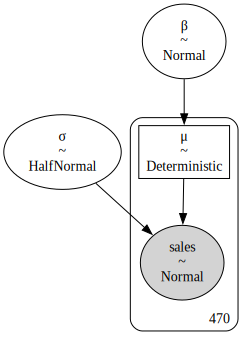

In [33]:
pm.model_to_graphviz(model_sales_pooled)

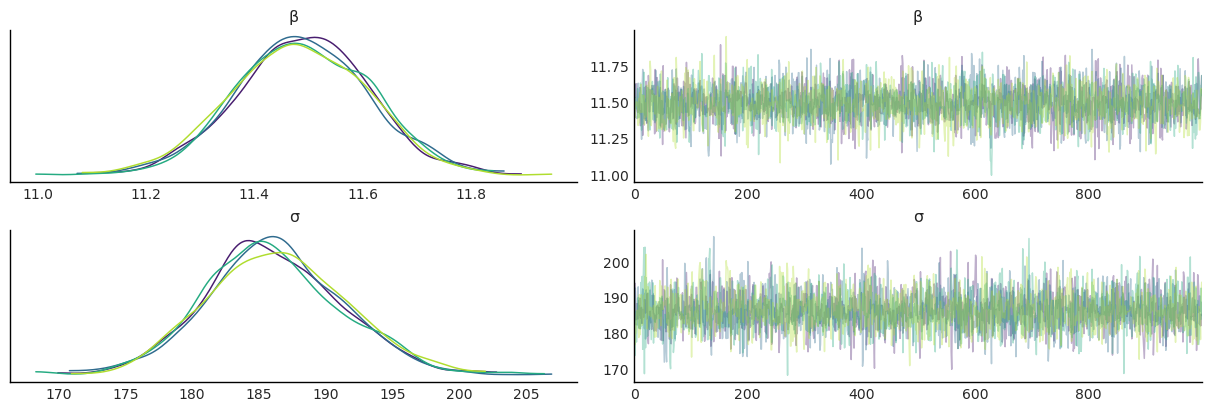

In [34]:
az.plot_trace(inf_data_sales_pooled, var_names=["β", "σ"], compact=False);


Text(0.5, 1.0, 'Comparison of pooled and unpooled models \n 94% HDI')

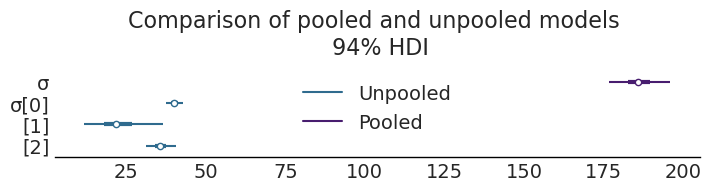

In [37]:
axes = az.plot_forest([inf_data_sales_pooled, trace_sales_unpooled],
                      model_names = ["Pooled", "Unpooled"], var_names=["σ"], combined=True, figsize=(7, 1.8));
axes[0].set_title("Comparison of pooled and unpooled models \n 94% HDI")

In [40]:
ppc_sales_pooled

Inference data with groups:
	> posterior_predictive
	> observed_data

Text(0.5, 1.0, 'Pooled Regression')

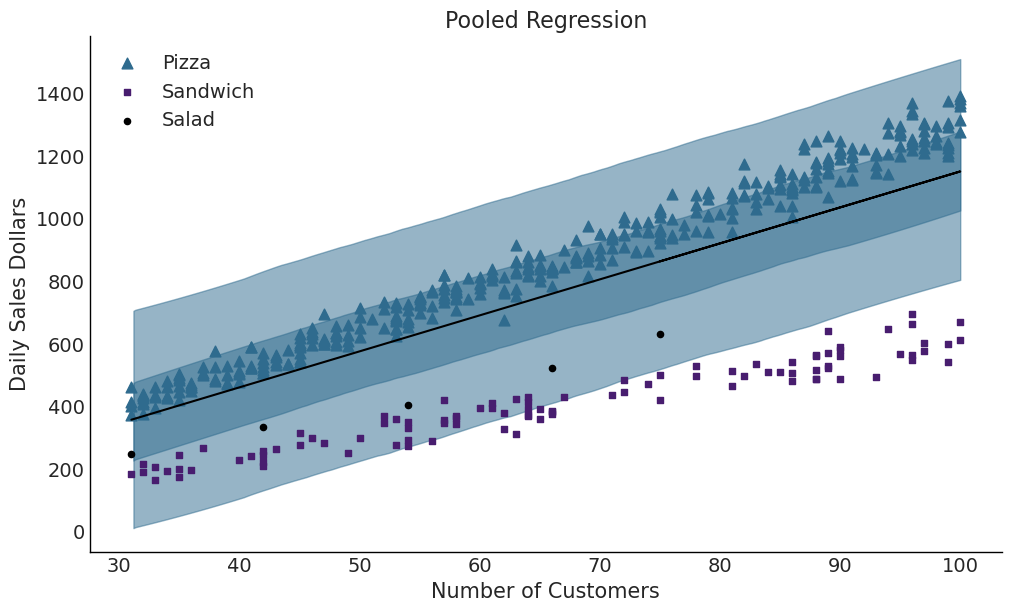

In [41]:
fig, ax = plt.subplots(figsize=(10, 6))
μ_m = inf_data_sales_pooled.posterior["μ"].values.reshape(-1, sales_df.shape[0]).mean(axis=0)
σ_m = inf_data_sales_pooled.posterior["σ"].mean().values

ax.plot(customers, μ_m, c='C4')

az.plot_hdi(customers, ppc_sales_pooled.posterior_predictive["sales"], hdi_prob=.50, ax=ax)
az.plot_hdi(customers, ppc_sales_pooled.posterior_predictive["sales"], hdi_prob=.94, ax=ax)


pizza_df.plot(x="customers", y="sales", kind="scatter", ax=ax, c="C1", label="Pizza", marker="^", s=60);
sandwich_df.plot(x="customers", y="sales", kind="scatter", ax=ax,  label="Sandwich", marker="s");
salad_df.plot(x="customers", y="sales", kind="scatter", ax=ax, label="Salad", c="C4");


ax.set_xlabel("Number of Customers")
ax.set_ylabel("Daily Sales Dollars")
ax.set_title("Pooled Regression")
# plt.savefig("img/chp04/salad_sales_basic_regression_scatter_pooled.png")

In [42]:
with pm.Model() as model_hierarchical_sales:
    σ_hyperprior = pm.HalfNormal("σ_hyperprior", 20)
    σ = pm.HalfNormal("σ", σ_hyperprior, shape=3)
    
    β = pm.Normal("β", mu=10, sigma=20, shape=3)
    μ = pm.Deterministic("μ", β[food_category.codes] * customers)
    
    sales = pm.Normal("sales", mu=μ, sigma=σ[food_category.codes],
                      observed=sales_observed)
    
    trace_hierarchical_sales = pm.sample(target_accept=.9)
    
    # inf_data_hierarchical_sales = az.from_pymc3(
    #     trace=trace_hierarchical_sales, 
    #     coords={"β_dim_0":food_category.categories,
    #             "σ_dim_0":food_category.categories})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ_hyperprior, σ, β]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


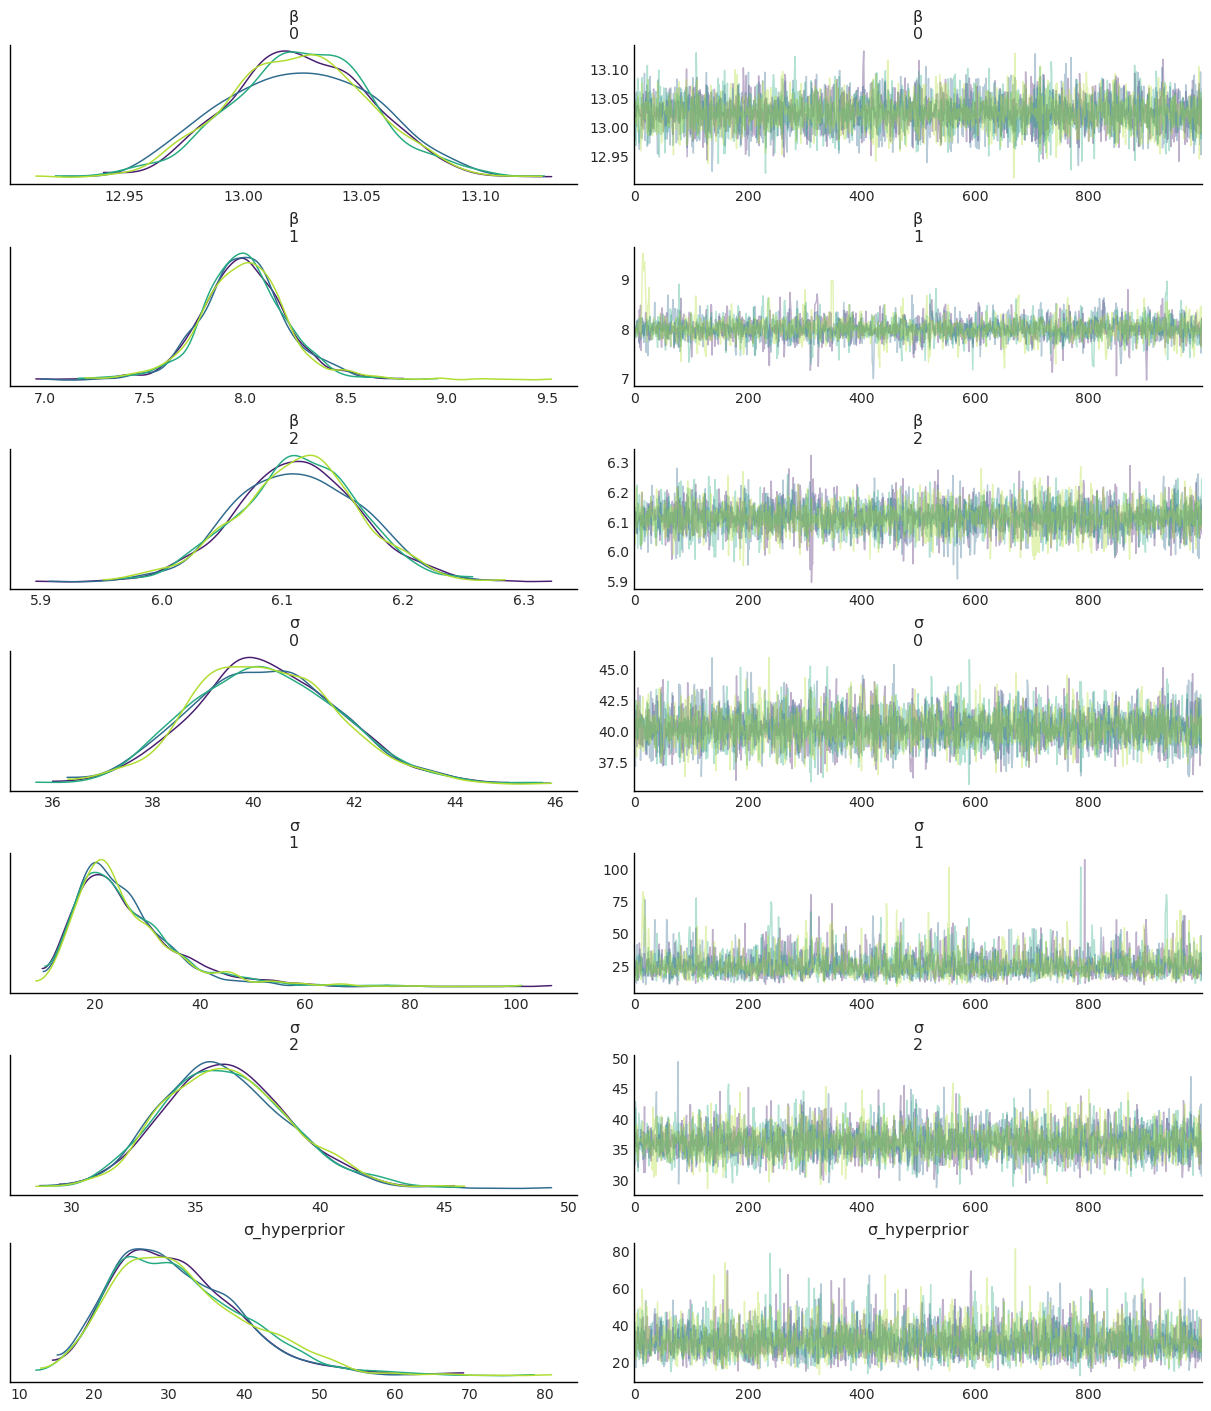

In [44]:
az.plot_trace(trace_hierarchical_sales, compact=False, var_names=["β", "σ", "σ_hyperprior"]);

In [45]:
az.summary(trace_hierarchical_sales, var_names=["β", "σ"])


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β[0],13.024,0.030,12.964,13.077,0.000,0.000,7516.0,3460.0,1.0
β[1],7.992,0.225,7.543,8.388,0.005,0.003,3131.0,1789.0,1.0
β[2],6.113,0.052,6.017,6.211,0.001,0.000,5937.0,2765.0,1.0
σ[0],40.244,1.467,37.346,42.839,0.018,0.013,6654.0,2981.0,1.0
σ[1],25.739,9.826,11.176,43.342,0.187,0.142,3916.0,2558.0,1.0
σ[2],36.213,2.561,31.521,41.060,0.032,0.023,6320.0,3062.0,1.0


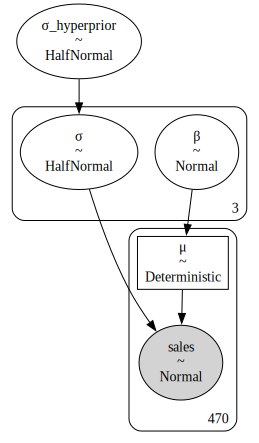

In [46]:
pm.model_to_graphviz(model_hierarchical_sales)

Text(0.5, 1.0, 'Hierarchical β estimates 94% HDI')

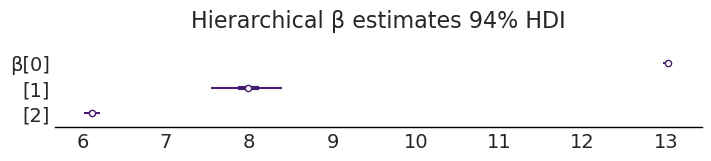

In [47]:
axes = az.plot_forest(trace_hierarchical_sales, var_names=["β"], combined=True,  figsize=(7, 1.5))
axes[0].set_title("Hierarchical β estimates 94% HDI")